# PAAM Alignment & Pedestal Requirements Analysis   

In [144]:
%matplotlib widget
import numpy as np
from numpy import cos, sin
from matplotlib import pyplot
from colorama import Back
from trafo import * 

# to build and manage the scenegraph we use the paytransform3d library
from pytransform3d.transform_manager import TransformManager 

# init the scenegraph
sg = TransformManager()

# define axis indices
X, Y, Z = (0, 1, 2)

In [145]:
# Definition of:
# the MOSA frame relative to the SC frame (rotation of 30deg aroung Z to match constellation angle plus some arbitrary translation)

sc2mosa1_trafo = frame_transformation([0,1,0],Z,30./180.*np.pi)

# the OB frame relative to the MOSA frame (just a translation along X)
mosa2ob_trafo = frame_transformation([0.5,0,0],0,0)

# the PAAM frame relative to the OB frame (achieved with a tranlation and two rotations)
ob2paam_trafo_1 = frame_transformation([0.0,0.05,-0.12],X, -135./180.*np.pi)
ob2paam_trafo_2 = frame_transformation([0,0,0],Y, 90./180.*np.pi)

ob2paam_trafo = ob2paam_trafo_2 @ ob2paam_trafo_1

paam2mirror_trafo1 = frame_transformation([0.0,0.0,0],X,0) # mirror roll
paam2mirror_trafo2 = frame_transformation([0.0,0.0,0],Y,0) # static offset
paam2mirror_trafo3 = frame_transformation([0.0,0.0,0],Z,0) # actuated DOF

paam2mirror_trafo = paam2mirror_trafo3 @ paam2mirror_trafo2 @ paam2mirror_trafo1

# add the transformations to the scenegraph
sg.add_transform("SC","MOSA", sc2mosa1_trafo)
sg.add_transform("MOSA","OB", mosa2ob_trafo)
sg.add_transform("OB","PAAM_OIRF", ob2paam_trafo)
sg.add_transform("PAAM_OIRF","PAAM_MIRROR", paam2mirror_trafo)


# variable transformation that defines the PAAM mirror frame based on static offset rotation around PAAM OIRF Y (ETA)
#apply_paam_static_rotation =  lambda rot: sg.add_transform("PAAM_OIRF","PAAM_Mirror", frame_transformation([0,0,0],Y, rot)) 

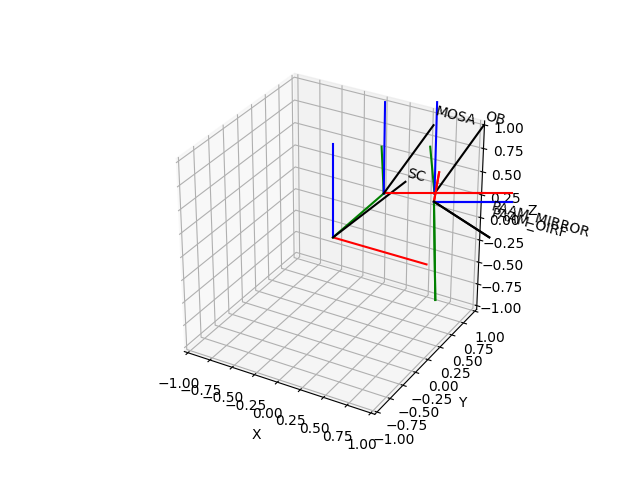

In [146]:
pyplot.figure()
ax = sg.plot_frames_in("SC", s=1)
pyplot.show()

In [147]:
def update_paam_mirror(sg, x,y,z,rx,ry,rz):
    paam2mirror_trafo0 = frame_transformation([x,y,z],X,0) # mirror roll
    paam2mirror_trafo1 = frame_transformation([0,0,0],X,rx) # mirror roll
    paam2mirror_trafo2 = frame_transformation([0.0,0.0,0],Y,ry) # static offset
    paam2mirror_trafo3 = frame_transformation([0.0,0.0,0],Z,rz) # actuated DOF

    paam2mirror_trafo = paam2mirror_trafo3 @ paam2mirror_trafo2 @ paam2mirror_trafo1 @ paam2mirror_trafo0 # sequence is here, 1st we roll and translate the frame (pedestal/ paam feet), then we apply static offset, and last stage is the paam mirror

    sg.add_transform("PAAM_OIRF","PAAM_MIRROR", paam2mirror_trafo)
    

In [148]:
class Ray:

    def __init__(self, init_pos, init_dir, frame, sg) -> None:

        self.pos = np.array(init_pos)
        self.dir = np.array(init_dir)
        self.definition_frame = frame
        self.sg = sg

class Mirror:

    def __init__(self, frame) -> None:
        self.definition_frame = frame

    

In [149]:
ray= Ray([0,0.0,-0.12,1],[0,1,0,0],"OB",sg)
paam_mirror = Mirror("PAAM_MIRROR")

In [150]:
def raytrace(ray, entity):
    # raytraces from the TX clip to behind PAAM

    # calculate ray in paam mirror frame

    ob2paam_mirror = sg.get_transform(ray.definition_frame,entity.definition_frame)

    ray_local_dir = ob2paam_mirror @ ray.dir 
    ray_local_pos = ob2paam_mirror @ ray.pos
    #print(ray_local_dir, ray_local_pos)

    # calculate intersection point with local y-z plane (x = 0) https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection

    l_0 = ray_local_pos[:3]
    n = np.array([1,0,0])
    l = ray_local_dir[:3]

    d = np.dot((-l_0),n)/np.dot(l,n)

    #print(d)

    p = l_0 + l*d

    #print(p)

    # apply reflection http://www.sunshine2k.de/articles/coding/vectorreflection/vectorreflection.html

    w = l - 2 * np.dot(l,n) * n 

    #print (l,w)

    # transform back to original coordinates

    return sg.get_transform(entity.definition_frame,ray.definition_frame) @ np.append(p, 1) , sg.get_transform(entity.definition_frame,ray.definition_frame) @ np.append(w, 0)

Auxilliary methods

In [151]:
def measure_pathlength(start_ray, reflected_ray):
    # measures the pathlength considering a flat wavefront perpendicular to the beam vector
    pass

def plot_angular(ray_list, frame, coordinates):
    pass

def plot_lateral(ray_list, frame, coordinates):
    pass

Do a nominal alignment raytrace first as a sanity check

In [152]:
raytrace(ray, paam_mirror)

(array([ 0.  ,  0.05, -0.12,  1.  ]),
 array([ 8.65956056e-17, -2.22044605e-16,  1.00000000e+00,  0.00000000e+00]))

## Start to calculate the set of 6 DOF alignment sensitivities
### Mirror actuated Axis vs OIRF alignment

In [153]:
out_list = []
parameter_list = []

for parameter_a in np.linspace(-10e-3,10e-3,20):
    for parameter_b in [-300e-6, +300e-6]:

        update_paam_mirror(sg,0,0,0,parameter_a,-157.508e-6 ,parameter_b)

        pos,dir = raytrace(ray, paam_mirror)
        
        #print(parameter,pos,dir)

        out_list.append(Ray(pos,dir,"OB",sg))
        parameter_list.append(parameter_a)


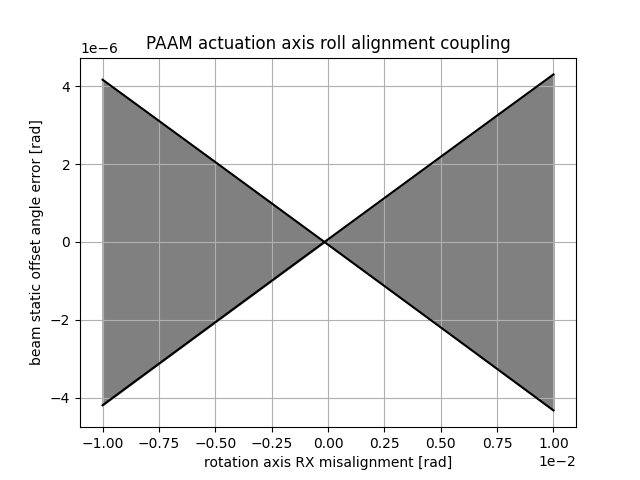

In [158]:
pyplot.figure()

trace_u = [ray.dir[0] for ray in out_list]
trace_v = [ray.dir[1] for ray in out_list]

pyplot.plot(parameter_list[0::2], np.subtract(trace_u[0::2],222.75e-6), c="black")
pyplot.plot(parameter_list[1::2], np.subtract(trace_u[1::2],222.75e-6), c="black")
pyplot.xlabel("rotation axis RX misalignment [rad]")
pyplot.ylabel("beam static offset angle error [rad]")
pyplot.fill_between(parameter_list[0::2],np.subtract(trace_u[0::2],222.75e-6),np.subtract(trace_u[1::2],222.75e-6), color="gray")
pyplot.grid("both")
pyplot.ticklabel_format(style="sci",scilimits=[0,0])
pyplot.title("PAAM actuation axis roll alignment coupling")
pyplot.show()

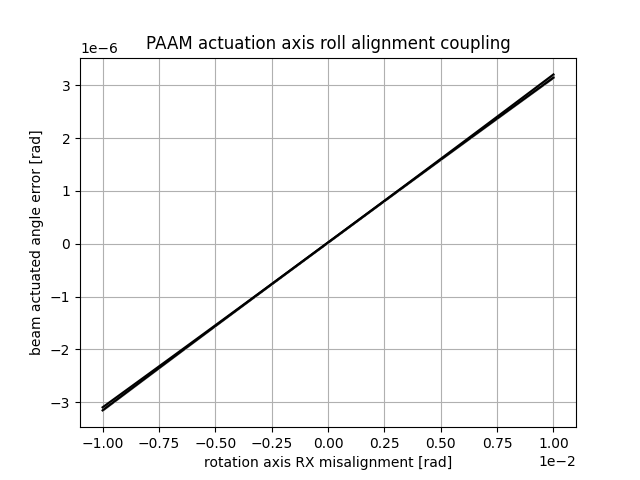

In [164]:
pyplot.figure()

trace_u = [ray.dir[0] for ray in out_list]
trace_v = [ray.dir[1] for ray in out_list]

pyplot.plot(parameter_list[0::2], np.subtract(trace_v[0::2],600e-6), c="black")
pyplot.plot(parameter_list[1::2], np.subtract(trace_v[1::2],-600e-6), c="black")
pyplot.xlabel("rotation axis RX misalignment [rad]")
pyplot.ylabel("beam actuated angle error [rad]")
pyplot.fill_between(parameter_list[0::2],np.subtract(trace_v[0::2],600e-6),np.subtract(trace_v[1::2],-600e-6), color="gray")
pyplot.grid("both")
pyplot.ticklabel_format(style="sci",scilimits=[0,0])
pyplot.title("PAAM actuation axis roll alignment coupling")
pyplot.show()

we need to be better than 1mrad for roll axis alignment